In [139]:
from neuron import h
h.load_file('stdrun.hoc')
import numpy as np
import matplotlib.pyplot as plt
from stellate import Stellate
h.celsius = 37.0
h.steps_per_ms = 40
h.dt = 0.025
h.cvode_active(0)

0.0

In [179]:
stellate_0 = Stellate(0)
stell_theta_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic.dur = 1e9
stell_theta_ic.dur = 1e9

time_dur = 5000  # ms

mean, std = -2.75e-3, 3e-4
time_steps = int(time_dur / h.dt)

noise_arr = np.random.normal(0, std, time_steps)

half = time_steps // 2

# baseline inhibition
noise_arr[:half] += mean

delta = 2.5e-3   
noise_arr[half:] += mean + delta

noise_vec = h.Vector(noise_arr)
noise_vec.play(stellate_noise_ic._ref_amp, h.dt)  
#stellate_noise_ic.amp = -5e-3
theta_amp = 0.0
theta_freq = 10.0
theta_arr = theta_amp * np.sin(2 * np.pi * theta_freq * np.arange(0, time_dur, h.dt) / 1000)
theta_vec = h.Vector(theta_arr)
theta_vec.play(stell_theta_ic._ref_amp, h.dt)

nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc_stell.threshold = 0
spike_times_stell = h.Vector()
nc_stell.record(spike_times_stell)

stell_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
noise_input = h.Vector().record(stellate_noise_ic._ref_amp)
theta_input = h.Vector().record(stell_theta_ic._ref_amp)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
time = h.Vector().record(h._ref_t)



In [181]:
h.finitialize(-65)
h.continuerun(time_dur)



0.0

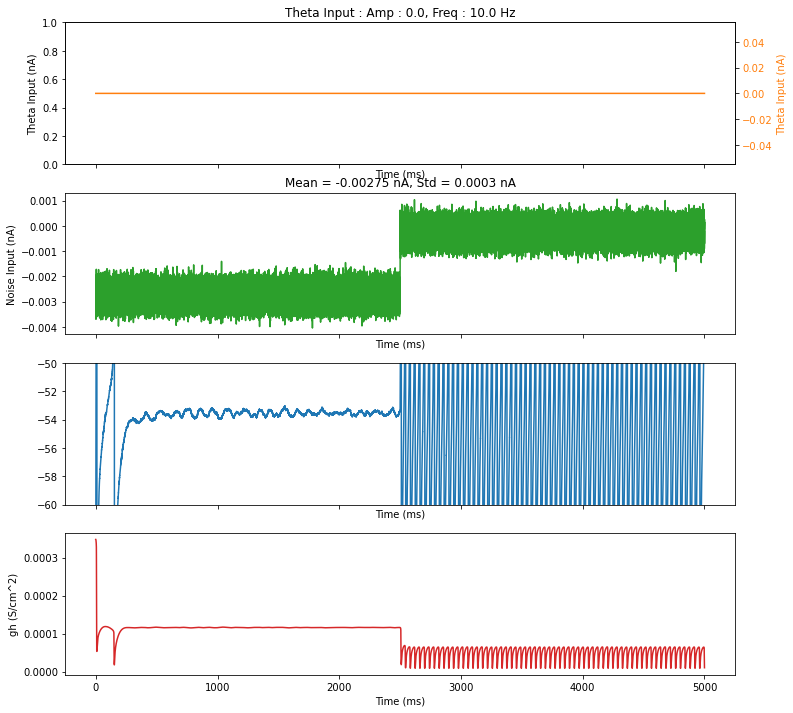

In [182]:

fig,ax = plt.subplots(4,1,figsize=(12, 12), sharex=True)
ax1 = ax[0].twinx()
ax1.plot(time, theta_input.to_python(), color='C1', label='Theta Input')
ax1.set_ylabel("Theta Input (nA)", color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
#plt.plot(time,noise_input.to_python())
ax[2].plot(time, stell_v.to_python())
ax[0].set_xlabel("Time (ms)")
ax[2].set_xlabel("Time (ms)")
ax[1].set_xlabel("Time (ms)")
ax[0].set_ylabel("Theta Input (nA)")
ax[1].set_ylabel("Noise Input (nA)")
ax[0].set_title(f"Theta Input : Amp : {theta_amp}, Freq : {theta_freq:.1f} Hz")
ax[1].set_title(f"Mean = {mean} nA, Std = {std} nA")
ax[1].plot(time,noise_input.to_python(), color='C2', label='Noise Input')
ax[3].plot(time, stellate_gh_vec.to_python(), color='C3', label='gh')
ax[3].set_xlabel("Time (ms)")
ax[3].set_ylabel("gh (S/cm^2)")
ax[2].set_ylim(-60,-50)

plt.show()

In [183]:
spike_times_array = spike_times_stell.to_python()
print("Spike times (ms):", spike_times_array)
print("Interspike intervals (ms):", np.diff(spike_times_array))

Spike times (ms): [5.350000000100042, 149.10000000010132, 2505.949999998695, 2541.5249999981775, 2580.52499999761, 2619.9999999970355, 2659.274999996464, 2698.849999995888, 2738.6749999953086, 2778.2499999947327, 2817.749999994158, 2857.1499999935845, 2896.899999993006, 2936.149999992435, 2975.999999991855, 3015.724999991277, 3055.649999990696, 3095.424999990117, 3135.07499998954, 3175.274999988955, 3214.9749999883775, 3254.4249999878034, 3293.9999999872275, 3333.9999999866454, 3373.599999986069, 3413.474999985489, 3452.7249999849178, 3492.224999984343, 3531.749999983768, 3571.4749999831897, 3611.1999999826116, 3650.899999982034, 3690.1749999814624, 3729.9499999808836, 3769.449999980309, 3809.1249999797315, 3848.6249999791567, 3888.2749999785797, 3927.974999978002, 3967.3999999774283, 4006.599999976858, 4045.974999976285, 4085.6999999757068, 4125.3999999751295, 4165.349999974548, 4205.174999973969, 4244.599999973395, 4284.049999972821, 4323.699999972244, 4363.199999971669, 4402.9999999

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


200001


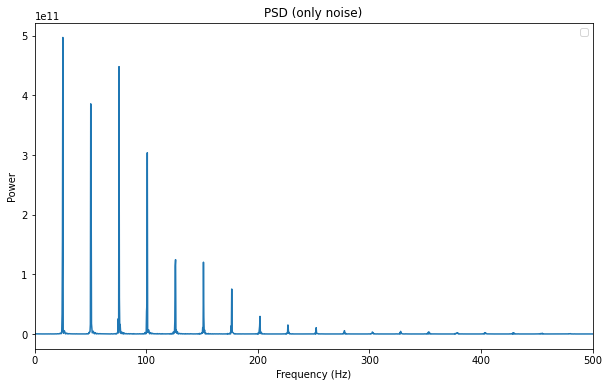

In [186]:
import analysis_utils as a_utils
print(len(stell_v.to_python()))
fft_freq,fft_sig,fft_power = a_utils.calc_fft(stell_v.to_python()[80000:])
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, fft_power)
plt.xlim(0, 350)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.axvline(x=1000/37.1, color='r', linestyle='--', label=f'Dominant Frequency: {1000/62.2:.2f} Hz  ')
#plt.axvline(x=theta_freq, color='r', linestyle='--')
plt.xlim(0,1000)
plt.title("PSD (only noise)")
plt.legend()
plt.xlim(0,500)
plt.show()

Impedance Analysis

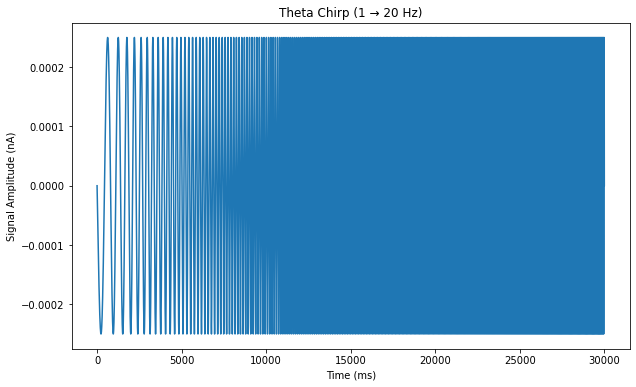

In [162]:
time_arr = np.arange(0, 30000, h.dt)  # ms
t_sec = time_arr / 1000.0                # convert to seconds

min_freq = 1.0
max_freq = 20.0
theta_amp = -2.5e-3

k = (max_freq - min_freq) / (t_sec[-1])  # Hz per second

phase = 2 * np.pi * (min_freq * t_sec + 0.5 * k * t_sec**2)

signal_arr = theta_amp/10 * np.sin(phase)

plt.figure(figsize=(10,6))
plt.plot(time_arr, signal_arr)
plt.xlabel("Time (ms)")
plt.ylabel("Signal Amplitude (nA)")
plt.title("Theta Chirp (1 → 20 Hz)")
plt.show()

1200000


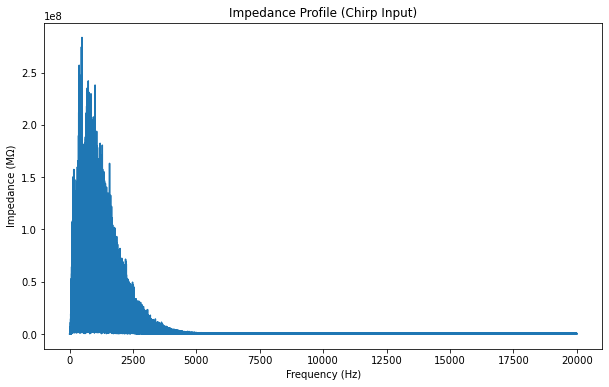

max  283537522.7494601
at 490.4997956250852
Q factor: 2550.585651801468


In [110]:
chirp_ic = h.IClamp(stellate_0.soma(0.5))
chirp_ic.dur = 1e9
chirp_vec = h.Vector(signal_arr)
chirp_vec.play(chirp_ic._ref_amp, h.dt)

imp_i = h.Vector().record(chirp_ic._ref_amp)
imp_v= h.Vector().record(stellate_0.soma(0.5)._ref_v)

time = h.Vector().record(h._ref_t)
h.finitialize(-55)
h.continuerun(time_dur*3)

i_mean = np.mean(imp_i.to_python())
imp_i_arr = imp_i.to_python() - i_mean
v_mean = np.mean(imp_v.to_python())
imp_v_arr = imp_v.to_python() - v_mean

volt_fft_freq, volt_fft_sig, volt_fft_power = a_utils.calc_fft(imp_v_arr)
curr_fft_freq, curr_fft_sig, curr_fft_power = a_utils.calc_fft(imp_i_arr)

print(len(curr_fft_freq))
impedance = np.abs(volt_fft_sig / curr_fft_sig)
plt.figure(figsize=(10, 6))
plt.plot(curr_fft_freq, impedance)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (MΩ)")
plt.title("Impedance Profile (Chirp Input)")   
     
plt.show()  


print("max ",np.max(impedance))
print("at", curr_fft_freq[np.argmax(impedance)])
print("Q factor:", np.max(impedance) / impedance[0])